# Задание 1 

In [11]:
import pandas as pd

# Данные по числу автомобилей на улице и в гараже за 5 рабочих дней
data = {
    'День': ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница'],
    'Улица': [80, 98, 75, 91, 78],
    'Гараж': [100, 82, 105, 89, 102]
}

# Создадим DataFrame
df = pd.DataFrame(data)

# Выводим данные
print(df)

          День  Улица  Гараж
0  Понедельник     80    100
1      Вторник     98     82
2        Среда     75    105
3      Четверг     91     89
4      Пятница     78    102


### Задание 1.1

In [12]:
# Корреляция Пирсона между «Улица» и «Гараж»
correlation = df['Улица'].corr(df['Гараж'], method='pearson')
print(f"Корреляция между числом автомобилей на улице и в гараже: {correlation:.4f}")

Корреляция между числом автомобилей на улице и в гараже: -1.0000


### Задание 1.2

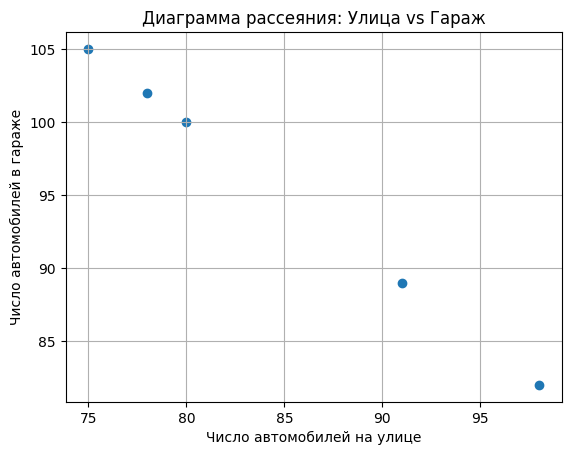

In [13]:
# Построение диаграммы рассеяния
import matplotlib.pyplot as plt

plt.scatter(df['Улица'], df['Гараж'])
plt.title("Диаграмма рассеяния: Улица vs Гараж")
plt.xlabel("Число автомобилей на улице")
plt.ylabel("Число автомобилей в гараже")
plt.grid(True)
plt.show()


# Задание 2

In [14]:
# Загрузка данных
df_insurance = pd.read_csv('insurance.csv')

# Посмотрим на первые строки
print(df_insurance.head())

# Посмотрим общую информацию о данных
print(df_insurance.info())

# Выведем описание числовых признаков
print(df_insurance.describe())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000 

### Задание 2.1

In [15]:
df_insurance_encoded = pd.get_dummies(df_insurance, drop_first=True)

# Теперь построим корреляционную матрицу для числовых признаков
correlation_matrix = df_insurance_encoded.corr()

# Выведем корреляционную матрицу
print(correlation_matrix)

# Найдём переменную, которая наиболее коррелирует с целевой переменной (charges)
target_variable = 'charges'
correlations_with_target = correlation_matrix[target_variable].drop(target_variable)

# Наиболее коррелирующая переменная
most_correlated_feature = correlations_with_target.idxmax()
max_correlation_value = correlations_with_target.max()

print(f"Наиболее коррелирующая переменная с '{target_variable}' — {most_correlated_feature} ({max_correlation_value:.4f})")

                       age       bmi  children   charges  sex_male  \
age               1.000000  0.109272  0.042469  0.299008 -0.020856   
bmi               0.109272  1.000000  0.012759  0.198341  0.046371   
children          0.042469  0.012759  1.000000  0.067998  0.017163   
charges           0.299008  0.198341  0.067998  1.000000  0.057292   
sex_male         -0.020856  0.046371  0.017163  0.057292  1.000000   
smoker_yes       -0.025019  0.003750  0.007673  0.787251  0.076185   
region_northwest -0.000407 -0.135996  0.024806 -0.039905 -0.011156   
region_southeast -0.011642  0.270025 -0.023066  0.073982  0.017117   
region_southwest  0.010016 -0.006205  0.021914 -0.043210 -0.004184   

                  smoker_yes  region_northwest  region_southeast  \
age                -0.025019         -0.000407         -0.011642   
bmi                 0.003750         -0.135996          0.270025   
children            0.007673          0.024806         -0.023066   
charges             0.78725

### Задание 2.2

In [16]:
import numpy as np

from sklearn.metrics import mean_squared_error

# Переменные для регрессии
X = df_insurance_encoded[most_correlated_feature].values
y = df_insurance_encoded[target_variable].values

# Реализация простой линейной регрессии
n = len(X)
X_mean = np.mean(X)
y_mean = np.mean(y)

# Вычисляем коэффициенты наклона и сдвига
numerator = np.sum((X - X_mean) * (y - y_mean))
denominator = np.sum((X - X_mean) ** 2)
slope = numerator / denominator
intercept = y_mean - slope * X_mean

# Вычисляем предсказания модели
y_pred = slope * X + intercept

# Среднеквадратичная ошибка (MSE)
mse = mean_squared_error(y, y_pred)

print(f"Наклон: {slope:.4f}")
print(f"Сдвиг (intercept): {intercept:.4f}")
print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")


Наклон: 23615.9635
Сдвиг (intercept): 8434.2683
Среднеквадратичная ошибка (MSE): 55720715.9542


### Задание 2.3

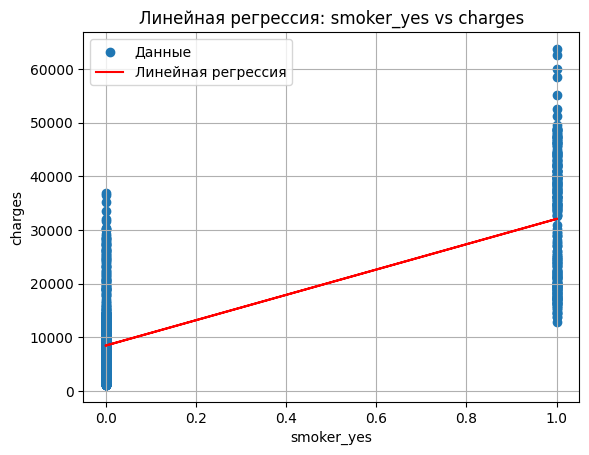

In [17]:
# Визуализация регрессии
plt.scatter(X, y, label='Данные')
plt.plot(X, y_pred, color='red', label='Линейная регрессия')
plt.title(f"Линейная регрессия: {most_correlated_feature} vs {target_variable}")
plt.xlabel(most_correlated_feature)
plt.ylabel(target_variable)
plt.legend()
plt.grid(True)
plt.show()


# Задание 3

In [18]:
# Выводим уникальные регионы
unique_regions = df_insurance['region'].unique()
print(f"Уникальные регионы: {unique_regions}")


Уникальные регионы: ['southwest' 'southeast' 'northwest' 'northeast']


### Задание 3.1

In [19]:
from scipy import stats

# Разделяем данные по регионам
regions_bmi = [df_insurance[df_insurance['region'] == region]['bmi'] for region in unique_regions]

# Выполняем однофакторный ANOVA тест
f_value, p_value = stats.f_oneway(*regions_bmi)

print(f"F-статистика: {f_value:.4f}")
print(f"P-значение: {p_value:.4f}")

if p_value < 0.05:
    print("Регионы статистически значимо влияют на индекс массы тела (BMI).")
else:
    print("Регионы не оказывают статистически значимого влияния на индекс массы тела (BMI).")


F-статистика: 39.4951
P-значение: 0.0000
Регионы статистически значимо влияют на индекс массы тела (BMI).


### Задание 3.2

In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Создадим модель линейной регрессии: BMI ~ region
model = ols('bmi ~ C(region)', data=df_insurance).fit()

# Выполним ANOVA тест
anova_results = anova_lm(model)

print(anova_results)


               df        sum_sq      mean_sq          F        PR(>F)
C(region)     3.0   4055.880631  1351.960210  39.495057  1.881839e-24
Residual   1334.0  45664.319755    34.231124        NaN           NaN


# Задание 3.3

In [25]:
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Получаем все пары регионов для парного теста
region_pairs = list(combinations(unique_regions, 2))
p_values = []

# Выполняем t-тест для каждой пары регионов
for pair in region_pairs:
    bmi_1 = df_insurance[df_insurance['region'] == pair[0]]['bmi']
    bmi_2 = df_insurance[df_insurance['region'] == pair[1]]['bmi']
    t_stat, p_val = stats.ttest_ind(bmi_1, bmi_2)
    p_values.append(p_val)

# Применяем поправку Бонферрони
_, p_adjusted, _, _ = multipletests(p_values, method='bonferroni')

# Выводим результаты
for i, pair in enumerate(region_pairs):
    print(f"Пара регионов {pair}: p-значение (с поправкой Бонферрони) = {p_adjusted[i]:.4f}")

# Вывод
significant_pairs = [pair for i, pair in enumerate(region_pairs) if p_adjusted[i] < 0.05]

if significant_pairs:
    print(f"Статистически значимые различия в BMI найдены между следующими парами регионов: {significant_pairs}")
else:
    print("Статистически значимых различий в BMI между регионами не найдено.")

Пара регионов ('southwest', 'southeast'): p-значение (с поправкой Бонферрони) = 0.0000
Пара регионов ('southwest', 'northwest'): p-значение (с поправкой Бонферрони) = 0.0065
Пара регионов ('southwest', 'northeast'): p-значение (с поправкой Бонферрони) = 0.0115
Пара регионов ('southeast', 'northwest'): p-значение (с поправкой Бонферрони) = 0.0000
Пара регионов ('southeast', 'northeast'): p-значение (с поправкой Бонферрони) = 0.0000
Пара регионов ('northwest', 'northeast'): p-значение (с поправкой Бонферрони) = 1.0000
Статистически значимые различия в BMI найдены между следующими парами регионов: [('southwest', 'southeast'), ('southwest', 'northwest'), ('southwest', 'northeast'), ('southeast', 'northwest'), ('southeast', 'northeast')]


Из полученных результатов t-тестов с поправкой Бонферрони можно сделать следующие выводы:

Существенные различия в индексе массы тела (BMI) обнаружены между несколькими парами регионов:

'southwest' и 'southeast': p-значение = 0.0000 (значительное различие).
'southwest' и 'northwest': p-значение = 0.0065 (значительное различие).
'southwest' и 'northeast': p-значение = 0.0115 (значительное различие).
'southeast' и 'northwest': p-значение = 0.0000 (значительное различие).
'southeast' и 'northeast': p-значение = 0.0000 (значительное различие).
Это говорит о том, что индекс массы тела (BMI) статистически значимо различается между данными регионами. В частности, регион 'southwest' имеет значительные различия по BMI с остальными регионами, как и 'southeast'.

Нет значимых различий между 'northwest' и 'northeast':

Для пары регионов 'northwest' и 'northeast' p-значение составило 1.0000, что указывает на отсутствие статистически значимых различий в BMI между этими регионами.
Интерпретация:
В регионах 'southwest' и 'southeast' индекс массы тела существенно отличается от других регионов. Это может указывать на то, что население этих регионов имеет определённые особенности в образе жизни, питании или других факторах, влияющих на BMI.
Регионы 'northwest' и 'northeast' не демонстрируют существенных различий по индексу массы тела. Это может указывать на схожие условия жизни или схожие поведенческие и культурные факторы, влияющие на здоровье населения.
В целом, значимые различия между регионами указывают на то, что географические факторы могут существенно влиять на индекс массы тела людей, что может быть полезно для дальнейшего изучения и выработки мер по поддержанию здоровья населения в этих регионах.

### Задание 3.4

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
northeast northwest   0.0263 0.9999 -1.1552  1.2078  False
northeast southeast   4.1825    0.0   3.033   5.332   True
northeast southwest   1.4231 0.0107  0.2416  2.6046   True
northwest southeast   4.1562    0.0  3.0077  5.3047   True
northwest southwest   1.3968 0.0127  0.2162  2.5774   True
southeast southwest  -2.7594    0.0 -3.9079 -1.6108   True
----------------------------------------------------------


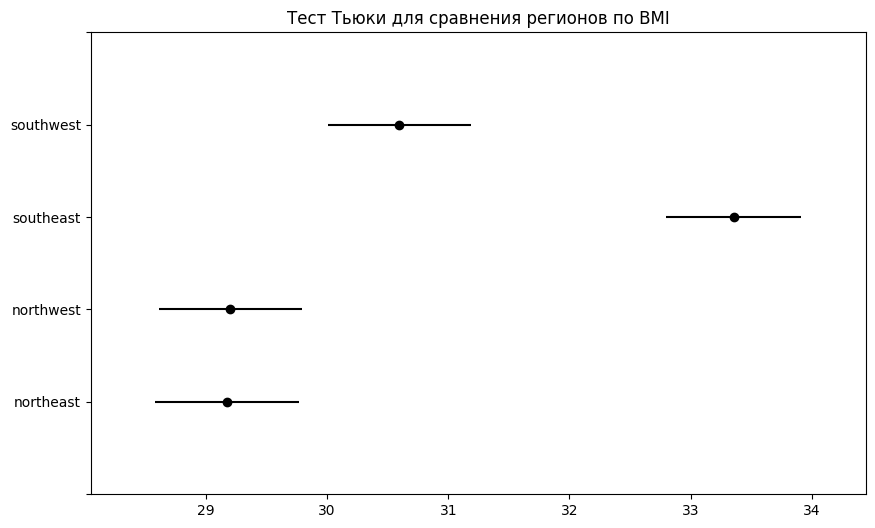

In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Пост-хок тест Тьюки для сравнения регионов по BMI
tukey_test = pairwise_tukeyhsd(endog=df_insurance['bmi'], groups=df_insurance['region'], alpha=0.05)

# Вывод результатов теста
print(tukey_test)

# Построим график
tukey_test.plot_simultaneous()
plt.title("Тест Тьюки для сравнения регионов по BMI")
plt.show()

### Задание 3.5

In [23]:
# Двухфакторная модель: BMI ~ region + sex
model_2way = ols('bmi ~ C(region) + C(sex)', data=df_insurance).fit()

# Выполним ANOVA тест
anova_results_2way = anova_lm(model_2way)

print(anova_results_2way)


               df        sum_sq      mean_sq          F        PR(>F)
C(region)     3.0   4055.880631  1351.960210  39.539923  1.773031e-24
C(sex)        1.0     86.007035    86.007035   2.515393  1.129767e-01
Residual   1333.0  45578.312720    34.192283        NaN           NaN


### Задание 3.6

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
northeast northwest   0.0263 0.9999 -1.1552  1.2078  False
northeast southeast   4.1825    0.0   3.033   5.332   True
northeast southwest   1.4231 0.0107  0.2416  2.6046   True
northwest southeast   4.1562    0.0  3.0077  5.3047   True
northwest southwest   1.3968 0.0127  0.2162  2.5774   True
southeast southwest  -2.7594    0.0 -3.9079 -1.6108   True
----------------------------------------------------------


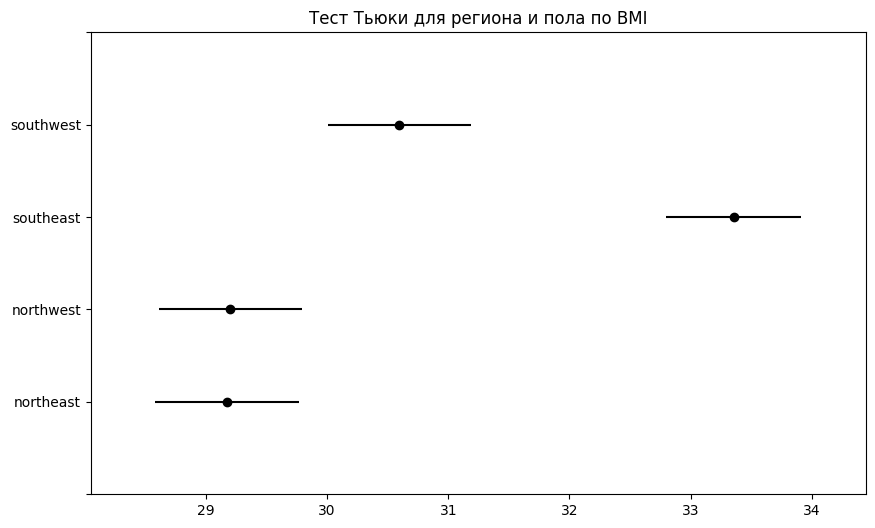

In [24]:
# Пост-хок тест Тьюки для региона и пола
tukey_test_sex_region = pairwise_tukeyhsd(endog=df_insurance['bmi'], groups=df_insurance['region'], alpha=0.05)

# Вывод результатов теста
print(tukey_test_sex_region)

# Построим график
tukey_test_sex_region.plot_simultaneous()
plt.title("Тест Тьюки для региона и пола по BMI")
plt.show()
